![banner](./images/banner.png "banner")

[Fuente de la imagen](https://unsplash.com/photos/Hcfwew744z4)
<a name='toc' />

# <font color=#ac6240>Cuantificación de la incertidumbre en la predicción de fallo cardíaco con aprendizaje automático supervisado</font>

### <font color=#ac6240>Tabla de Contenidos</font>

<a href=#pre>Requisitos previos</a><br>
1. <a href=#project-description>Descripción del proyecto</a><br>
    1.1 <a href=#project-description-intro>Introducción</a><br>
    1.2 <a href=#project-description-goal>Objetivo</a><br>
    1.3 <a href=#project-description-data>Datos y modelo de aprendizaje automático</a><br>
    1.4 <a href=#project-description-software>Software</a><br>
2. <a href=#prep>Preparación de los datos</a><br>
    2.1 <a href=#prep-clean> Limpieza de los datos</a><br>
    2.2 <a href=#prep-split> Division de los datos en conjuntos de datos de entrenamiento, validación y prueba</a><br>
    2.3 <a href=#prep-encoding> Codificación y normalización de las 'features'</a><br>
3. <a href=#model-ml>Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</a><br>
    3.1 <a href=#model-metric> Selección de la métrica y del umbral de decisión </a><br>
    3.2 <a href=#model-RF> Entrenamiento, prueba, y aplicación del bosque aleatorio </a><br>
4. <a href=#app-uq>Aplicación de métodos de cuantificación de incertidumbre</a><br>
    4.1 <a href=#uq-cp> Conformal Predictors </a><br>
    4.2 <a href=#uq-regression> Otros métodos de UQ para aprendizaje supervisado </a><br>
    4.3 <a href=#miscelanea> Miscelánea </a><br>
    
5. <a href=#uq-end>Conclusión sobre la cuantificación de incertidumbre</a><br>

Antes de nada, me gustaría agradecer a lxs expertxs [Maria Navarro](https://www.linkedin.com/in/maria-navarro-jimenez/) y a [Valeriy Manokhin](https://www.linkedin.com/in/valeriy-manokhin-phd-mba-cqf-704731236/) su inestimable ayuda en la elaboracion de este Jupyer Notebook. Podéis encontrar las referencias a sus trabajos acreditadas a lo largo de este taller.

<font size="5">😊 </font>

<a name='pre'/>

## <font color=#ac6240>Requisitos previos</font>

Este Jupyter Notebook es la continuación de los Jupyter Notebooks de [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI):
+ `Exploration_and_Classification.ipynb` donde explicamos cómo explorar exhaustivamente los datos de pacientes que sufrieron o no fallo cardíaco y cómo evaluar la calidad de un modelo de aprendizaje automático supervisado con métricas de rendimiento; elegimos el modelo que mejor se comportaba para este proyecto de predicción de fallo cardíaco y era un bosque aleatorio, y
+ `XAI.ipynb` donde aplicamos varios métodos de explicabilidad sobre las predicciones de ese bosque aleatorio para entender en qué se fijó el modelo para clasificar a les pacientes.

<font size="5"> 👍🤓</font>

<a name='project-description'/>

##  <font color=#ac6240>1. Descripción del proyecto</font>

<a name='project-description-intro'/>

### <font color=#ac6240>1.1 Introducción</font>

Estamos acostumbrades a modelos de aprendizaje automático que nos devuelven una predicción en forma de un único valor puntual ('single-value prediction'). Estos modelos no tienen ninguna manera de manifestar si están muy seguros o no de lo que predicen, por ejemplo, proporcionando una distribución o rango de resultados razonables, para que podamos representar la predicción con unas 'barras de error' en lugar de con un solo punto. 

La falta de información sobre la certeza que tiene un modelo sobre los resultados que arroja es especialmente problemático cuando:
+ el modelo no es interpretable, es una 'black box' o caja opaca, (explicamos estos conceptos en el Jupyter Notebook anterior `XAI.ipynb`), o
+ pedimos al modelo que prediga un resultado sobre una instancia anómala ('outlier') que no se parece a los datos históricos con los que ese modelo fue entrenado, algo relacionado con el fenómeno denominado ['drift'](https://en.wikipedia.org/wiki/Drift_(data_science)) (más info sobre la definición de 'deriva' o 'drift' y sus diferentes tipos, [aquí](https://analyticsindiamag.com/concept-drift-vs-data-drift-in-machine-learning/)), lo cual es indeseado y puede pasar fácilmente desapercibido. 

Por ejemplo, supongamos que entrenamos una red neuronal artificial (que no es interpretable) con fotos de perrxs y gatxs cuya tarea es distinguir entre perres y gates. Digamos que el umbral de decisión es tal que las instancias, es decir, las fotos, cuya 'raw score' sea mayor de 0.5 serán clasificadas como gates y el resto como perres, como en una típica clasificación binaria. Supongamos además que conseguimos que la red neuronal artificial tenga un rendimiento excelente sobre los datos de entrenamiento y validación, puede que incluso tenga un 99.5% en 'accuracy' sobre ambos conjuntos. Ahora, probamos la red y le pedimos que clasifique las fotos que vemos un poco más abajo y :
+ para la foto de la izquierda nos da una 'raw score' de 0.9, así que predice correctamente que es la imagen de unx gatx,
+ para la foto del centro obtenemos una 'raw score' de 0.5, y a la vista de la imagen _interpretamos_ que a la red le costó darnos una clasificación correcta (nos la dió por los pelos) y que obviamente no está _tan segura_ porque le perre de la imagen parece un poco une gate, pero...

¿y si le pedimos que clasifique la figura de la derecha? Cualquier cosa puede pasar, nos puede dar una 'raw score' por encima o por debajo de 0.5 o exactamente 0.5, pero en cualquier caso, sabemos que no es fiable. Y la cuestión es que **el modelo de aprendizaje automático no nos podría decir 'hey, no tengo ni idea' porque las 'raw scores' no muestran certidumbre**, a pesar de lo que todes hemos erróneamente interpretado alguna vez.  

![cat_dog_bird](./images/cat_dog_bird.png "cat_dog_bird")

[Fuente de la imagen: _"Are you sure about that?! Uncertainty Quantification in AI"_](https://florianwilhelm.info/2019/10/uncertainty_quantification_in_ai/)

Recordemos que **los modelos de aprendizaje automático supervisado están diseñados para interpolar, no para extrapolar (ni para identificar relaciones de causa-efecto, ni para abstraer conocimiento,... por lo cual les cuesta generalizar)**. Si no damos al modelo la oportunidad de avisarnos de que no está preparado para desempeñar la tarea, nos dará igualmente una predicción, y tomaremos que está igual de seguro de esa predicción como lo está de la predicción de una instancia estándar para la que sí está entrenado. Sería mucho más adecuado que el modelo de aprendizaje automático nos informara de la certeza de sus resultados.  

En otras palabras, saber qué no sabemos, es decir, cuantificar la incertidumbre, mejora la calidad de las decisiones para poder descartar las predicciones con alta incertidumbre y derivar las decisiones a expertes humanos, como ocurre a menudo en el denominado ['Active Learning'](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)).

#### <font color=#ac6240>1.1.1 Definición de Incertidumbre</font>

Según la Wikipedia en castellano (consultada el 26.09.2022):

![uncertainty_wp](./images/uncertainty_wp.png "uncertainty_wp")

[Fuente de la imagen](https://es.wikipedia.org/wiki/Incertidumbre)

Vamos, que el asunto va de lo que pasa cuando queremos medir u observar algo o predecir cuánto valdrá algo. 

Consultemos ahora a les expertes en [metrología](https://es.wikipedia.org/wiki/Metrolog%C3%ADa), es decir, la Oficina Internacional de Pesas y Medidas ([BIPM](https://www.bipm.org/en/committees/jc/jcgm/), por sus siglas en francés) cuyo Joint Committee for Guides in Metrology (JCGM) publica la Guía para la expresión de la Incertidumbre en la Medida (GUM, por sus siglas en inglés) que incluye el International Vocabulary of basic and general terms in Metrology ([VIM](https://www.bipm.org/en/committees/jc/jcgm/publications) JCGM_100_2008_E-1)

<font size="5">🤪🤯</font>


donde se define:

<blockquote>

**2.2 The term 'uncertainty'**

[...] Uncertainty (of measurement) [is a] parameter, associated with the result of a measurement, that characterizes the dispersion of the values that could reasonably be attributed to the measurand. [...] The parameter may be, for example, a standard deviation (or a given multiple of it), or the half-width of an interval having a stated level of confidence.
</blockquote>

y también:

<blockquote>
    
**3.3. Uncertainty**

The uncertainty of the result of a measurement reflects the lack of exact knowledge of the value of the measurand.
</blockquote>

Antes de ver qué significa esto en el contexto del aprendizaje automático, hagamos una aclaración importante para distinguir bien entre los conceptos de incentidumbre, error, residuo y sesgo o 'bias'.

#### <font color=#ac6240>1.1.2 Incertidumbre vs error vs residuo vs bias</font>

El **error** es la diferencia entre el valor verdadero, (asumiento que existe y se puede definir, ojo, que aquí esto es clave), y el valor resultado de la medición o predicción, por ejemplo, realizada empíricamente con un aparato de medida o en nuestro caso, el dato de si le paciente sufre o no fallo cardíaco. 

Si ese valor verdadero lo defimos por un modelo, esa diferencia entre la medición y el modelo también se llama **residuo**, por ejemplo, la distancia entre un punto `(x,y)` (el dato resultado de la medición) y la recta de regresión lineal que intenta representar a todos los datos, `y = mx + n`, y que idealizamos como representación de la realidad. Vimos la regresión lineal brevemente en la seccion 4.1 Modelo de referencia inicial para la selección de la métrica: Regresión Logística del Jupyter Notebook `Exploration_and_Classification.ipynb`.

Entonces, en la representacion tradicional, la desviación entre el valor obtenido de la medición y el ansiado supuesto valor verdadero se compone de dos tipos de errores:
+ el error aleatorio, la componente debida a la naturaleza [estocástica](https://en.wikipedia.org/wiki/Stochastic_process#Examples) del sistema, y
+ el error sistemático, también llamado **sesgo o 'bias'**, que es la componente reducible porque su media no es cero y se puede compensar con un 'factor de correccion' (mencionamos los problemas éticos del sesgo en IA en la intro del Jupyter Notebook `XAI.ipynb`).

En la Introducción del nuevo informe de 2012 [VIM 200:2012](https://www.bipm.org/en/committees/jc/jcgm/publications) se indica que estos dos tipos de errores no siempre son fáciles de diferenciar y que no disponemos de una regla general para ver cómo se combinan. Y también dice que normalmente estimamos el límite superior del valor absoluto del error total y que llamamos vagamente a eso 'incertidumbre'.

Pero la VIM también nos indica que es mejor no seguir ese punto de vista tradicional del 'error' porque:

+ necesita de la asumpción de la existencia un 'valor verdadero', y 
+ su objetivo es minimizar cualquier diferencia entre el resultado de la medida y ese supuesto 'valor verdadero', porque considera el error como una imperfección indeseable,

siendo más adecuado tratar la dispersión de los resultados de las mediciones como una 'incertidumbre' que:

+ aporta valiosa información y detalles significativos del comportamiento del sistema, y 
+ nos permite asumir que **la medición solo se puede expresar como un intervalo de valores razonables**.

<font size="5"> 👏 </font> 

Veamos ahora a qué nos referimos con "intervalo de valores razonable".

#### <font color=#ac6240>1.1.3 Intervalo de valores razonables</font>

Hay muchas maneras de definir qué entendemos por un 'intervalo de valores razonables' que nos permita cuantificar la variabilidad de los datos y por tanto, la incertidumbre de la medición.

Los métodos de UQ que aquí explicamos nos proveen de un [intervalo de predicción](https://en.wikipedia.org/wiki/Prediction_interval) para cada predicción, es decir, es una estimación del rango de valores que con la probabiliad que determinamos con el llamado 'nivel de confianza (por ejemplo, con 0.90 tendremos el 90% de probabilidad) incluirá el valor correcto de una futura medición. 

Centramos ahora en la incertidumbre en aprendizaje automático.

#### <font color=#ac6240>1.1.4 Incertidumbre en aprendizaje automático</font>

Cuando aplicamos un modelo de aprendizaje automático, queremos que nos diga cuándo no está seguro y cuánta incertidumbre está asociada a su predicción. 

Podriamos incluso intentar desglosar los tipos de incertidumbre según su origen. Por ejemplo, puede haber incertidumbre:
+ en cómo se tomaron y procesaron esos datos, (por ejemplo, la precisión de los aparatos de observación y medida, el etiquetado, el almacenamiento, ...), 
+ asociada al modelo (por ejemplo, en la elección del modelo, la estimación de parámetros, la regularizacion, ...), 
+ por culpa de los [sesgos](https://www.visualcapitalist.com/50-cognitive-biases-in-the-modern-world/), el desconocimiento, y el error humano, 

y un millón de factores más, que a menudo en aplicaciones prácticas no hace falta analizar. El origen de la incertidumbre o los tipos de incertidumbres que cuantizamos con métodos de UQ es un tema demasiado complicado que requiere 'domain expertise'.

Simplemente mencionaremos que en aprendizaje automático se suelen considerar [dos tipos de incertidumbre](https://deepai.org/publication/aleatoric-and-epistemic-uncertainty-in-machine-learning-a-tutorial-introduction) que se pueden resumir en:

+ Aleatoria: "¿saldrá cara o cruz si lanzo una moneda al aire?", incertidumbre relativa al dato individual, **que no es reducible**, ni aunque aumentamos el número de datos con el que entrenamos el modelo de aprendizaje automático, y

+ Epistémica: "¿me fío de que esta moneda no está trucada?", incertidumbre relativa a la certeza del modelo de aprendizaje automático después de a ver visto la instancia cuya 'target' ha de predecir, **sí se puede reducir** con más datos de entrenamiento.

Siguiendo con el ejemplo de la moneda de la charla [_"On estimating epistemic uncertainty"_](http://yingzhenli.net/home/pdf/epistemic_uncertainty_neurips_bdl2019.pdf), en realidad hay un tercer tipo de incertidumbre a tener en cuenta en aprendizaje automático:

+ 'Distribution' o 'Concept' o 'Data drift': "¿sigo aún lanzando la misma moneda?", incertidumbre relacionada con los cambios en la distribución de datos, cuando los nuevos datos no tienen la misma distribución que tenian los datos de entrenamiento (como dijimos anteriormente, para amplicar sobre la definición de 'deriva' o 'drift' y sus diferentes tipos, [aquí](https://analyticsindiamag.com/concept-drift-vs-data-drift-in-machine-learning/)). La librería [NannyML](https://github.com/NannyML/nannyml) sirve para detectar el 'data drift'.

Ejemplos de 'drift' son cambios en la resolución de la camara que hace las fotos para la clasificación de imagenes, la persona que etiqueta los datos para una clasificación, los gustos de les clientes para un 'sentiment analysis', ... o incluso la aparición de nuevos fenómenos, pensemos en la dificultad en la predicción de los efectos de cambio climático ya que los modelos de aprendizaje automáticos se basan en datos históricos recogidos cuando las temperaturas globales no eran tan altas. En otras palabras, los modelos no pueden conocer más allá de los datos con los que han sido entrenados.

![comic_uq](./images/comic_uq.png "comic_uq")

[Fuente de la Imagen](https://www.smbc-comics.com/comic/rise-of-the-machines)

Continuamos con la preparacion de los datos y el entrenamiento del modelo de aprendizaje automático. Si ya trabajaste con los dos Jupyter Notebooks anteriores y estás familiarizadx con los datos y el modelo del bosque aleatorio, puedes pasar directamente a las seccion <a href=#app-uq>4. Aplicación de métodos de cuantificación de incertidumbre</a>.

<font color=#6B8E23 size="4"> Material adicional y referencias</font>

<font color=#6B8E23 size="3">Ejemplos de los peligros de la 'single-point prediction'</font>

+ La espectacular charla del gran Vincent Warmerdamm ['How to constrain artificial stupidity'](https://youtu.be/Z8MEFI7ZJlA).
+ El libro _'Weapons of math destruction'_ de Cathy O'Neil, hay [versión en castellano](https://www.indienauta.com/armas-destruccion-matematica-cathy-oneil-capitan-swing-2018/)

<font color=#6B8E23 size="3">Conceptos de UQ</font>

+ En este blog, el articulo introductorio: [_"A Comprehensive Introduction to Uncertainty in Machine Learning"_](https://imerit.net/blog/a-comprehensive-introduction-to-uncertainty-in-machine-learning-all-una/#:~:text=One%20way%20to%20estimate%20aleatoric,create%20a%20subset%20of%20samples).
+ La referencia por definición, el libro gratuito [_"Probabilistic Machine Learning: Advanced Topics"_](https://probml.github.io/pml-book/book2.html), desde 2022 por fín incluye los 'Conformal Predictors', aún no lo leí pero tengo que hacerlo.

<font size="5"> 😅 </font>

<a name='project-description-goal'/>

### <font color=#ac6240>1.2 Objetivo</font>

En este Jupyter Notebook vamos a aplicar algunas técnicas de UQ a los resultados del modelo de bosque aleatorio (que no es interpretable) que entrenamos en el Jupyter Notebook `Exploration_and_Classification.ipynb`. No incluimos explicaciones exhaustivas y demostraciones matemáticas (hay muchas otras fuentes, ver la lista de materiales arriba), mejor mencionaremos algunas características intuitivas sobre la cuantificación de la incertidumbre y nos enfocaremos en su implementación en Scikit-learn.

Como dijimos, si ya conoces alguno de los dos Jupyter Notebook anteriores ya estarás familiarize con los datos y con el bosque aleatorio, puedes pasar directamente a la sección <a href=#app-uq> 4. Aplicación de métodos de cuantificación de incertidumbre</a>.

<a name='project-description-data'/>

### <font color=#ac6240>1.3 Datos y modelo de aprendizaje automático</font>

Utilizaremos los datos y el modelo de aprendizaje automático del Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI).

**Datos**

Utilizaremos los datos del [Conjunto de datos de predicción de insuficiencia cardíaca de Kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction) (cita: fedesoriano. (Septiembre de 2021) Heart Failure Prediction Dataset), y

Recordamos que las 'features' o características son los datos de lxs paciente ('Age', 'Cholesterol',...) y la variable objetivo o 'target', es decir, lo que queremos predecir, se llama "HeartDisease", y es una variable binaria que toma los valores:
+ 1: sí, pacientes que sí presentan riesgo de padecer una cardiopatía
+ 0: no, pacientes que no presentan riesgo de padecer una cardiopatía

En relacion a la 'feature' 'Sex', vamos a interpretar que se refiere al sexo con el que nacieron esas personas. Por otro lado vemos que solo toma los valores 'M' (male) or 'F' (female), es decir, entendemos que no hay datos de personas intersexuales o no binarias.

**Modelo de aprendizaje automático para la clasificación**

El modelo de clasificación que utilizaremos es un bosque aleatorio que ya ajustamos, entrenamos, y validamos en el Jupyter Notebook anterior `Exploration_and_Classification.ipynb`. En este Jupyter Notebook directamente dividiremos el conjunto de datos en datos de entrenamiento y datos de prueba ('test'). Sobre esos datos de prueba aplicaremos el modelo de aprendizaje automático en la sección <a href=#model-ml>3. Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</a>.

Para cada nueve paciente, el modelo supervisado del bosque aleatorio anteriormente entrenado al aplicar `.predict_proba()` nos da una puntuación o 'raw score' que si esta cerca de '0' clasifica a ese paciente en el grupo de pacientes sin riesgo a sufrir fallo cardíaco y si esta cerca de '1' clasifica a ese paciente en el grupo de pacientes sin riesgo a sufrir fallo cardíaco (donde 'cerca' se define por el 'umbral de decisión' como explicamos en el anterior Jupyter Notebook `Exploration_and_Classification.ipynb`, sección 4. Entrenamiento de los modelos). A menudo se toma esa 'raw score' como probabilidad heurística (ver la Observación importante en ese mismo Jupyter Notebook) de que ese nueve paciente esté o no en riesgo de sufrir una insuficiencia cardíaca. Entonces, si el resultado de aplicar el modelo de aprendizaje automático sobre los datos de une paciente nos arroja una puntuación o 'raw score' de 0.7, si el umbral de decisión es igual a 0.4, le paciente quedará clasificade como 'perteniente al grupo en riesgo de sufrir fallo cardíaco'.

Y volvemos a remarcar que nuestro modelo solo es bueno encontrando correlaciones, (ni generaliza, ni entiende de relaciones de causa-efecto, ni conoce las restricciones del problema,...) por eso es fundamental que las decisiones finales sean tomadas por personas expertas en medicina. 

![ivory](./images/ivory_small.png "ivory")

[Fuente de la imagen: "Mean-squared-terror"](https://koaning.io/posts/mean-squared-terror/)

Como es claramente una decisión de vida o muerte y como el bosque aleatorio no es un modelo interpretable, además de aplicar métodos de XAI que explicamos en el Jupyter Notebook anterior, aplicaremos aquí métodos de UQ para dar una distribución de probabilidad rigurosa a los resultados que nos indique como de seguro está el modelo de aprendizaje automático de su predicción. Lo haremos en la siguiente sección <a href=#app-uq>4. Aplicación de métodos de cuantificación de incertidumbre </a>.

Hemos elegido trabajar sobre un conjunto de datos tabulares porque los modelos de aprendizaje automático y los métodos de UQ suelen ser más fáciles de entender si podemos ver las 'features' en columnas. Sin embargo los conceptos de UQ que explicamos aquí sirven para cualquier aplicación mientras sea de aprendizaje automático. 

<a name='project-description-software'/>

### <font color=#ac6240>1.4 Software</font>

Usaremos estas librerías:

In [1]:
import pandas as pd     
import numpy as np

# data exploration and preparation  
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer 
from sklearn.preprocessing import StandardScaler 

# model
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# UQ 
#from sklearn.linear_model import QuantileRegressor
#import nonconformist extension scikit-learn



# model evaluation
from sklearn.metrics import accuracy_score, f1_score, auc, recall_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score


# plotting and displaying in the notebook
import seaborn as sns
from matplotlib import pyplot as plt
#from IPython.display import display
#import emoji

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<a href=#toc>Subir a la Tabla de Contenidos</a><br>

<a name='prep'/>

## <font color=#ac6240>2. Preparación de los datos</font>

La exploración y preparación de los datos se hizo en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), aquí solo mostarmos los pasos esenciales.

<a name='prep-clean'/>

### <font color=#ac6240>2.1 Limpieza de los datos</font>

Cargamos los datos del fichero que esta en el mismo repositorio:

In [2]:
df = pd.read_csv("heart_failure.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


'FastingBS' (la presión sanguínea en ayunas) debería ser una variable categórica ya que los valores actuales de '0' y '1' son solamente representaciones de valores cualitativos que no queremos que el modelo interprete como valores cuantitativos.

In [3]:
# Transform the categorical values wrongly classified as numericals
new_values = {
    0: 'L', # low
    1: 'H', # high
}

df.FastingBS = df.FastingBS.map(new_values)
# type(df.FastingBS[0]) # uncomment to check that it is a string type

In [4]:
# Store in different lists the names of the categorical and numerical columns since they will be treated different 
categorical = df.select_dtypes(include=['object']).columns.tolist()  # for strings 
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist() # for numbers

Los valores mínimos de 'RestingBP' y 'Cholesterol' son cero, lo cual es sospechoso. Con experiencia en el campo de la medicina, podríamos decidir si reemplazar estos valores nulos por la media u otro valor. Carecemos de esta información, por lo tanto, simplemente eliminamos esas filas.

In [5]:
index_to_drop = list(df.loc[(df.RestingBP == 0) | (df.Cholesterol == 0)].index)
df.drop(index_to_drop, inplace=True)

<font size ='5'> ✌️ </font>No hay necesidad de más limpieza de datos.

<a name='prep-split'/>

### <font color=#ac6240>2.2 División de los datos en conjuntos de datos de entrenamiento, validación y prueba</font>

En esta división aleatoria, y en todas las ocasiones siguientes en las que usemos un generador de números aleatorios, fijamos la semilla del generador de números aleatorios para asegurar la reproducibilidad de los resultados. Fijamos el `random_state = 1` pero podría ser 2 o cualquier otro valor, no afectará a los resultados, pero con esta corrección siempre obtendremos exactamente los mismos resultados.

Recordamos que dividimos el conjunto de datos en entrenamiento y prueba porque la exploración de los datos y el ajuste y la validación del modelo de clasificación ya lo hicimos en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI).

In [6]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df.copy() 
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64','float64']).columns.tolist()
numerical.remove('HeartDisease')

In [7]:
numerical

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [8]:
# first separate the train from the test set
df_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
len(df_train), len(df_test)

(596, 150)

In [9]:
# reset index
df_train = df_train.reset_index(drop=True)
# define the target
y_train = df_train.HeartDisease.values
# remove the target from the features
del df_train['HeartDisease']

<a name='prep-encoding'/>       

### <font color=#ac6240>2.3 Codificación y normalización de las 'features'</font>

Para codificar las características categóricas usamos Scikit-Learn `DictVectorizer`, que toma un diccionario y lo convierte en un vector, es decir, en un` numpy.array`. Es un método de los llamados One-Hot Encoding (OHE) para convertir las características categóricas (no afectaría las numéricas si se lo aplicasemos) en columnas con valores binarios, con tantas columnas como valores tome la variable categórica. Por ejemplo, la columna de la caracteristíca 'ExcerciseAngina' que podía tener valores 'N' o 'Y' ahora dará lugar a dos columnas, una llamada 'ExcerciseAngina=N' y otra 'ExcerciseAngina=Y' que claramente son dependientes (dan la misma información) y están totalmente correlacionadas (cuando el valor de una es '0', el valor de la otra es seguro '1', ver las correlaciones en el Jupyter Notebook anterior). Cualquier método de codificación añade por tanto información redundante. Hemos de eliminar la información redundante desechando una de las columnas de cada par correlacionado (da igual qué columna de cada par eliminemos, ambas dan la misma información), quitaremos 'ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up':

In [10]:
dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
train_dict = df_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_train_cat = dv.fit_transform(train_dict) # make it a vector

df_X_train_cat = pd.DataFrame(X_train_cat,columns= dv.get_feature_names())
# remove redundant columns
df_X_train_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
                    axis=1, inplace=True)
# convert the dataframe to a np.array again
X_train_cat = df_X_train_cat.to_numpy()

categorical_update = df_X_train_cat.columns.to_list()

En el Jupyter Notebook de la exploración y clasificación de los datos usamos Scikit-Learn `StandardScaler` para normalizar las características numéricas entre 0 y 1. Así, aquellas columnas con valores en un rango más alto no tendrían más representación y modelos como la regresión logística convergían mejor. Como aquí usamos un bosque aleatorio, no necesitamos escalar las 'features' numéricas. 

In [11]:
#scaler = StandardScaler()

# TRAIN
X_train_num = df_train[numerical].values
#X_train_num = scaler.fit_transform(X_train_num)

Unimos las matrices numéricas y categóricas:

In [12]:
# TRAIN
X_train = np.column_stack([X_train_num, X_train_cat])

Las nuevas características son:

In [13]:
feature_names = numerical + categorical_update
feature_names

['Age',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ChestPainType=ASY',
 'ChestPainType=ATA',
 'ChestPainType=NAP',
 'ChestPainType=TA',
 'ExerciseAngina=Y',
 'FastingBS=L',
 'RestingECG=LVH',
 'RestingECG=Normal',
 'RestingECG=ST',
 'ST_Slope=Down',
 'ST_Slope=Flat',
 'Sex=M']

<font size="5"> 👏 </font>  Ya tenemos todo para entrenar nuestro bosque aleatorio.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='model-ml'/>

## <font color=#ac6240>3. Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</font>

Entrenaremos el modelo de aprendizaje supervisado llamado bosque aleatorio ('Random Forest') que es uno de los clasificadores de aprendizaje automático más populares (ver, por ejemplo, [Kaggle 2021](https://storage.googleapis.com/kaggle-media/surveys/Kaggle's%20State%20of%20Machine%20Learning%20and%20Data%20Science%202021.pdf) página 32). En el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI) probamos varios modelos de clasificación y el bosque aleatorio resultó ser el ganador.

El bosque aleatorio es un tipo de [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning): corremos en paralelo muchos árboles de decisión y tomamos la predicción del que obtuvo más aciertos. Primero, se crean múltiples conjuntos de datos de entrenamiento mediante el muestreo de datos del conjunto de datos de entrenamiento (un método conocido como 'bootstrapping' o 'bagging') y luego se entrena un árbol de decisión en cada uno de estos conjuntos de datos.  Pueden usarse para resolver problemas de regresión o de clasificación. Por lo general, los bosques aleatorios tienen un alto rendimiento, pero no son interpretables (son 'black-boxes') y no son recomendables para grandes conjuntos de datos (~ TB) porque requieren mucha más potencia de computadora que la regresión logística, por ejemplo.

<a name='model-metric'/>

### <font color=#ac6240>3.1 Selección de la Métrica y del umbral de decisión</font>

En el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), decidimos medir la calidad del modelo con la metrica denominada 'F1-score' porque **queremos evitar los Falsos Negativos (no queremos diagnostiar como sanx a unx paciente en riesgo)**. Además, contaremos la tasa de Verdaderos Positivos (o 'recall') y no perderemos de vista la precisión ('precision') y exactitud ('accuracy').


Por último, concluimos que definíamos el umbral de decisión en `t = 0.4`.

<a name='model-RF'/>

### <font color=#ac6240>3.2 Entrenamiento, prueba, y aplicación del bosque aleatorio</font>

No vamos a repetir todo el proceso de ajuste y validación sino que directamente entrenamos y probamos ('test') el modelo de clasificación para poder comenzar la cuantificación de la incertidumbre en el siguiente apartado. 

#### <font color=#ac6240>3.2.1 Entrenamiento y prueba del bosque aleatorio</font>

Entrenamos el modelo ganador con los datos de entrenamiento: 

In [14]:
# train the machine learning model: random forest

RF = RandomForestClassifier(max_depth = 10, min_samples_leaf = 5, 
                            n_estimators =  50, random_state = 1)

model = RF.fit(X_train, y_train)

Vamos aplicarlo sobre los datos de prueba, primero los preparamos:

In [15]:
# preparation TEST data

# reset index after the splitting shuffling
df_test = df_test.reset_index(drop=True)
# define target of the test set
y_test = df_test.HeartDisease.values
   
# 1. encode the categorical features and remove redundant columns-------------    

test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) 

# convert the data array to a dataframe
df_X_test_cat = pd.DataFrame(X_test_cat,columns= dv.get_feature_names())

# remove redundant columns
df_X_test_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
                    axis=1, inplace=True)

# convert the dataframe to a np.array again
X_test_cat = df_X_test_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------

X_test_num = df_test[numerical].values
#X_test_num = scaler.transform(X_test_num) 

# 3. join the matrices -------------------------------------------------------

X_test = np.column_stack([X_test_num, X_test_cat]) 

In [16]:
# model application on TEST data
y_pred = RF.predict_proba(X_test)[:, 1]

# metrics analysis
t = 0.4

acc = accuracy_score(y_test, y_pred >= t) 
rec = recall_score(y_test, y_pred >= t)
f1  = f1_score(y_test, y_pred >= t) 
auc = roc_auc_score(y_test, y_pred)
print('For the test dataset:',
      'ACC:', acc.round(3), 'Recall:', rec.round(3),'F1:', f1.round(3),
      'ROC AUC:', auc.round(3))
# output:
# For the test dataset: ACC: 0.893 Recall: 0.924 F1: 0.901 ROC AUC: 0.942

For the test dataset: ACC: 0.893 Recall: 0.924 F1: 0.901 ROC AUC: 0.942


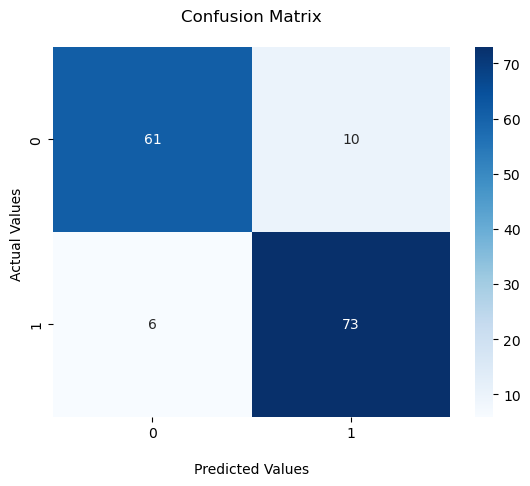

In [17]:
# confusion matrix

cf_matrix = confusion_matrix(y_test, y_pred >= t)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

##plt.figure(figsize=(7,5))
plt.rcParams['figure.figsize'] = [7, 5]  # re-run this cell to get the correct figure size

plt.show();

<font size="5"> 👏 </font> Como es un contexto médico, queremos evitar los Falsos Negativos y hemos obtenido solo 6, con un porcentaje de aciertos de aproximadamente el 90% (ver los valores de las métricas obtenidos), no está mal. Además, vimos en el Jupyter Notebook anterior que estos hiperparametros nos dan valores de las métricas similares a los de los conjuntos de datos de entrenamiento y validación, por lo que no estamos sobreajustadando ('overfitting') y esperamos que el modelo generalice bien.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

#### <font color=#ac6240>3.2.2 Aplicación del bosque aleatorio</font>

Simulemos una nueva paciente con los siguientes datos:

In [18]:
new_patient = {
    'Age': 56,
    'Sex': 'F',
    'ChestPainType': 'ATA', 
    'RestingBP': 130,  
    'Cholesterol': 150, 
    'FastingBS': 'L',
    'RestingECG': 'ST',
    'MaxHR': 115,
    'ExerciseAngina': 'N',
    'Oldpeak': 1.,
    'ST_Slope': 'Flat',
 }

Preparamos los datos de entrada como en la sección <a href=#prep>2. Preparación de los datos</a>:

In [19]:
num_dict = dict()
cat_dict = dict()
    
for (key, value) in new_patient.items():
    if key in numerical:
        num_dict[key] = value
    else:
        cat_dict[key] = value

# DictVect input must be a dict
X_cat = dv.transform(cat_dict) # encode the categorical features
df_X_cat = pd.DataFrame(X_cat,columns= dv.get_feature_names()) # convert array to df
df_X_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
              axis=1, inplace=True) # remove redundant columns
X_cat = df_X_cat.to_numpy() # convert the dataframe to a np.array again

# Scaler input must be a np.array
X_num = np.array(list(num_dict.values())).reshape(1, -1)
#X_num = scaler.transform(X_num) # scale the numerical features

# Join both arrays
X = np.column_stack([X_num, X_cat]) 

y aplicamos el modelo de clasificación:

In [20]:
print()
y_pred = RF.predict_proba(X)[:, 1]
print('Application of the Random Forest classifier to a new patient:')
print()
print("The patient raw score of suffering a hear failure is:", y_pred[0].round(2))
t = 0.4
print()
print("With t =", t, "as the decision threshold, is there a risk of suffering a heart failure?")
print(y_pred[0] >= t)


Application of the Random Forest classifier to a new patient:

The patient raw score of suffering a hear failure is: 0.32

With t = 0.4 as the decision threshold, is there a risk of suffering a heart failure?
False


Empezamos ya a implementar métodos de UQ que permiten predecir la distribución esperada de la predicción en lugar de un único valor puntual. Identificaremos así cuando nuestro modelo no está seguro de su predicción y podremos reducir el número de Falsos Negativos.

![Molnar_UQ](./images/Molnar_UQ.png "Molnar_UQ")

[Fuente de la imagen](https://twitter.com/ChristophMolnar)

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='app-uq'/>

## <font color=#ac6240>4. Aplicación de métodos de cuantificacion de incertidumbre</font>

Como mencionamos en la 'Observación importante' de la seccion 4. Entrenamiento de los modelos en el primer Jupyter Notebook de la serie `Exploration_and_Classification.ipynb`, las librerías más populares de Python (Scikit-learn, XGBoost, Keras…) púntuan las prediciones con el método `predict_proba()` que, a pesar de su nombre, en realidad no produce probabilidades (ver por ejemplo, el artículo [_"Are you sure that's a probability?"_](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html)) porque las puntuaciones crudas o 'raw scores' que nos dan estos modelos no están calibradas. Esto causa consecuencias desastrosas a la hora de inferir verdadera información, como se explica en [_"How to calibrate your classifier in an intelligent way using Machine Learning Conformal Prediction"_](https://valeman.medium.com/how-to-calibrate-your-classifier-in-an-intelligent-way-a996a2faf718).

Aquí vamos a explicar la familia de métodos denominados ['Conformal Predictors'](https://en.wikipedia.org/wiki/Conformal_prediction) los cuales funcionan tanto para clasificación como para regresión y nos permiten calibrar nuestras 'raw scores' para que sean verdaderas probabilidades. Aplicamos uno muy sencillo que funciona muy bien para clasificaciones binarias en la sección <a href=#uq-cp>4.1 Conformal Predictors</a>.

<a name='uq-cp'/>

### <font color=#ac6240>4.1 Conformal Predictors</font>

La ['Conformal Prediction'](https://en.wikipedia.org/wiki/Conformal_prediction) es un método para cuantizar la rareza de una predicción respecto al resto de valores de la variable de destino o 'target'. Para ello, hemos de establecer una medida de no conformidad, o 'nonconformity measure' que cuantice cuán diferente es la  predicción dentro del conjunto de predicciones que obtuvimos al predecir el conjunto de entrenamiento. Una alta 'nonconformity' indica que el nuevo dato es raro, como lx pájarx en el ejemplo de la Introducción. Lxs cientificxs de datos que aplicamos la 'Conformal Prediction' nos llamamos 'nonconformists'.

<font size="5">😎<font/>

La 'Conformal Prediction':

+ funciona para cualquier modelo de aprendizaje automático,
+ se aplica en el 'post-procesing' sobre las predicciones del modelo de aprendijaze automático ya entrenado,
+ requiere pocas líneas de código y es rápida, 
+ funciona para datos recogidos en tiempo real, es decir, 'online assimilation',
+ es 'model-agnostic' y ni siquiera necesita conocer al modelo de aprendizaje automático para el que está cuantizando la incertidumbre de sus predicciones,     
+ ofrece una garantía de cobertura: los conjuntos de predicciones resultantes vienen con garantías de cubrir el resultado verdadero con una probabilidad determinada,
+ a diferencia de los métodos paramétricos, no es necesario asumir que la variable de destino o 'target' está distribuida según una distribución normal, y 

de hecho, la unica condición es que las instancias sean [intercambiables](https://en.m.wikipedia.org/wiki/Exchangeable_random_variables), es decir, que el orden de los datos no importe, (como en nuestro caso, lxs pacientes no tienen que estar ordenadxs) lo cual es una restricción menos fuerte que la restricción que tienen todos los modelos de aprendizaje automatico sobre que los datos han de ser independientes e estar idénticamente distributidos o [iid](https://es.wikipedia.org/wiki/Variables_aleatorias_independientes_e_id%C3%A9nticamente_distribuidas). 

Así, la 'Conformal Prediction' nos cuantifica la incertidumbre en forma de intervalos de predicción, también llamados 'conformal intervals', que con garantía incluye la prediccion correcta con cierta probabilidad, lo cual se llama 'coverage guarantee'. Entonces, en lugar de obtener predicciones puntuales ('single-point predictions'), es decir, un número real en el caso de una regresión o la etiqueta de una clase en el caso de una clasificación, los resultados calibrados con 'Conformal prediction' nos dan un intervalo de números reales o un conjunto de etiquetas, respectivamente.
    
Por ejemplo, aplicando 'Conformal Prediction' a los resultados de un modelo de aprendizaje automático (una CUDA de Deep Neural Network en PyTorch) para una clasificación de imágenes, vemos que éste:
    
+ no está muy seguro de si la primera foto era un osciloscopio, así que nos lo ofrece como primera opción en un intervalo con otras dos opciones, 'microondas' y 'portítil', 
+ tampoco está muy seguro de la foto central, de nuevo nos dió la respuesta correcta como primera opción pero el intervalo contiene también 'refrigerador' y ' lavadora', y
+ está muy seguro de que en la foto de la derecha hay unx perrx de raza 'Irish Setter' (seguro que ha visto muchos como esx, para el modelo no es una imagen rara), y es la única opción del intervalo de resultados:

![CP_example](./images/CP_4.png "CP_example")

[Fuente de la imagen: Google Colab de A. Angelopoulos desarrollador de MAPIE](https://colab.research.google.com/github/aangelopoulos/conformal_classification/blob/master/example.ipynb#scrollTo=oIiBD-pFVdkD)

Recordamos que el intervalo de predicción que obtenemos con la 'Conformal Prediccion' no es un mero ranking de las 'raw scores' de cada clase si no una verdadera probabilidad de que el modelo ha visto una imagen parecida antes o no.

Apliquemos la 'Conformal Prediction' a las predicciones de nuestro bosque aleatorio. Usamos la implementación del repositorio de [Paolo Toccaceli](https://github.com/ptocca/VennABERS/) denominada 'Inductive Venn-ABERS Prediction (IVAP)' descrita en el artículo [_"Large-scale probabilistic prediction with and without validity guarantees"_](http://alrw.net/articles/13.pdf).

In [21]:
# Some elementary functions to speak the same language as the paper
# (at some point we'll just replace the occurrence of the calls with the function body itself)
def push(x,stack):
    stack.append(x)
    
def pop(stack):
    return stack.pop()

def top(stack):
    return stack[-1]

def nextToTop(stack):
    return stack[-2]

# perhaps inefficient but clear implementation
def nonleftTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)<=0

def nonrightTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)>=0

def slope(a,b):
    ax,ay = a
    bx,by = b
    return (by-ay)/(bx-ax)

def notBelow(t,p1,p2):
    p1x,p1y = p1
    p2x,p2y = p2
    tx,ty = t
    m = (p2y-p1y)/(p2x-p1x)
    b = (p2x*p1y - p1x*p2y)/(p2x-p1x)
    return (ty >= tx*m+b)

kPrime = None

# Because we cannot have negative indices in Python (they have another meaning), I use a dictionary

def algorithm1(P):
    global kPrime
    
    S = []
    P[-1] = np.array((-1,-1))
    push(P[-1],S)
    push(P[0],S)
    for i in range(1,kPrime+1):
        while len(S)>1 and nonleftTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S

def algorithm2(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack

    F1 = np.zeros((kPrime+1,))
    for i in range(1,kPrime+1):
        F1[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i-1] = P[i-2]+P[i]-P[i-1]
        if notBelow(P[i-1],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonleftTurn(P[i-1],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i-1],Sprime)
    return F1

def algorithm3(P):
    global kPrime

    S = []
    push(P[kPrime+1],S)
    push(P[kPrime],S)
    for i in range(kPrime-1,0-1,-1):  # k'-1,k'-2,...,0
        while len(S)>1 and nonrightTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S

def algorithm4(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack
    
    F0 = np.zeros((kPrime+1,))
    for i in range(kPrime,1-1,-1):   # k',k'-1,...,1
        F0[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i] = P[i-1]+P[i+1]-P[i]
        if notBelow(P[i],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonrightTurn(P[i],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i],Sprime)
    return F0

def prepareData(calibrPoints):
    global kPrime
    
    ptsSorted = sorted(calibrPoints)
    
    xs = np.fromiter((p[0] for p in ptsSorted),float)
    ys = np.fromiter((p[1] for p in ptsSorted),float)
    ptsUnique,ptsIndex,ptsInverse,ptsCounts = np.unique(xs, 
                                                        return_index=True,
                                                        return_counts=True,
                                                        return_inverse=True)
    a = np.zeros(ptsUnique.shape)
    np.add.at(a,ptsInverse,ys)
    # now a contains the sums of ys for each unique value of the objects
    
    w = ptsCounts
    yPrime = a/w
    yCsd = np.cumsum(w*yPrime)   # Might as well do just np.cumsum(a)
    xPrime = np.cumsum(w)
    kPrime = len(xPrime)
    
    return yPrime,yCsd,xPrime,ptsUnique

def computeF(xPrime,yCsd):
    global kPrime
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})
    
    S = algorithm1(P)
    F1 = algorithm2(P,S)
    
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})    
    P[kPrime+1] = P[kPrime] + np.array((1.0,0.0))    # The paper says (1,1)
    
    S = algorithm3(P)
    F0 = algorithm4(P,S)
    
    return F0,F1

def getFVal(F0,F1,ptsUnique,testObjects):
    pos0 = np.searchsorted(ptsUnique,testObjects,side='left')
    pos1 = np.searchsorted(ptsUnique[:-1],testObjects,side='right')+1
    return F0[pos0],F1[pos1]

def ScoresToMultiProbs(calibrPoints,testObjects):
    # sort the points, transform into unique objects, with weights and updated values
    yPrime,yCsd,xPrime,ptsUnique = prepareData(calibrPoints)
    
    # compute the F0 and F1 functions from the CSD
    F0,F1 = computeF(xPrime,yCsd)
    
    # compute the values for the given test objects
    p0,p1 = getFVal(F0,F1,ptsUnique,testObjects)
                    
    return p0,p1

Aplicando la función `ScoresToMultiProbs()` a  la lista de pares '(raw_score, target value)' de las predicciones del bosque aleatorio que obtuvimos sobre el conjunto de entrenamiento, y la 'raw score' de la instancia dada, en nuestro caso, unx paciente, obtenemos el límite inferior 'p0' y superior 'p1' de la probabilidad bien calibrada para la clase '1', en nuestro caso la probabilidad de pertenecer al grupo en riesgo de sufrir fallo cardíaco. La probabilidad de 'HeartDisease=1' para esx paciente se calcula con la formula `p1/(1 - p0 + p1)`.

In [22]:
# model application on TRAINIG data to get the 'raw scores'
y_pred_train = RF.predict_proba(X_train)[:, 1]

Tomemos unx paciente al azar y apliquemos la 'Conformal Prediction':

In [23]:
patient_number = 2
individual_prediction_array = X_test[patient_number : (patient_number + 1)]
#df_X_test.iloc[patient_number].values.reshape(1, -1)
y_pred_test = RF.predict_proba(individual_prediction_array)[0][1].round(2)
print("Prediction risk of heart disease:", y_pred_test)
print("Actual risk of heart disease:", y_test[patient_number])

# apply Conformal Prediction
p0,p1 = ScoresToMultiProbs(list(zip(y_pred_train,y_train)),y_pred_test)
# p0 and p1 are both probabilities of class 1 (lower and upper bound)
# the difference tells us how hard it is to classify this instance
print('The prediction interval is [', p0.round(2),',', p1.round(2),']', 'with lenght', (p1 - p0).round(2))
print('The actual probability of the patient to suffer heart failure is:', (p1/(1 - p0 + p1)).round(2) )

Prediction risk of heart disease: 0.69
Actual risk of heart disease: 1
The prediction interval is [ 0.88 , 0.9 ] with lenght 0.02
The actual probability of the patient to suffer heart failure is: 0.89


Estx es unx paciente con fallo cardíaco que el bosque aleatorio clasificó correctamente pero vemos que su probabilidad rigurosa es mayor que lo que predecía la puntuación cruda.

In [24]:
patient_number = 12  
individual_prediction_array = X_test[patient_number : (patient_number + 1)]
#df_X_test.iloc[patient_number].values.reshape(1, -1)
y_pred_test = RF.predict_proba(individual_prediction_array)[0][1].round(2)
print("Prediction risk of heart disease:", y_pred_test)
print("Actual risk of heart disease:", y_test[patient_number])

# apply Conformal Prediction
p0,p1 = ScoresToMultiProbs(list(zip(y_pred_train,y_train)),y_pred_test)
# p0 and p1 are both probabilities of class 1 (lower and upper bound)
# the difference tells us how hard it is to classify this instance
print('The prediction interval is [', p0.round(2),',', p1.round(2),']', 'with lenght', (p1 - p0).round(2))
print('The actual probability of the patient to suffer heart failure is:', (p1/(1 - p0 + p1)).round(2) )

Prediction risk of heart disease: 0.82
Actual risk of heart disease: 0
The prediction interval is [ 0.94 , 0.98 ] with lenght 0.04
The actual probability of the patient to suffer heart failure is: 0.94


Estx es unx paciente sin fallo cardíaco que el bosque aleatorio clasificó incorrectamente. Vemos que conformal las probabilidades no nos corrige los resultados mal clasificados, si no que nos avisa si hay incertidumbre en la clasificación, nos dice que es uan predicción rara. De hecho, el intervalo de predicción mide el doble que en el caso de lx paciente anterior que si estaba bien clasificada.

In [25]:
patient_number = 30
individual_prediction_array = X_test[patient_number : (patient_number + 1)]
#df_X_test.iloc[patient_number].values.reshape(1, -1)
y_pred_test = RF.predict_proba(individual_prediction_array)[0][1].round(2)
print("Prediction risk of heart disease:", y_pred_test)
print("Actual risk of heart disease:    ", y_test[patient_number])

# apply Conformal Prediction
p0,p1 = ScoresToMultiProbs(list(zip(y_pred_train,y_train)),y_pred_test)
# p0 and p1 are both probabilities of class 1 (lower and upper bound)
# the difference tells us how hard it is to classify this instance
print('The prediction interval is [', p0.round(2),',', p1.round(2),']', 'with lenght', (p1 - p0).round(2))
print('The actual probability of the patient to suffer heart failure is:', (p1/(1 - p0 + p1)).round(2) )

Prediction risk of heart disease: 0.29
Actual risk of heart disease:     0
The prediction interval is [ 0.11 , 0.14 ] with lenght 0.02
The actual probability of the patient to suffer heart failure is: 0.13


En estx último ejemplo tenemos unx paciente sin fallo cardíaco que el bosque aleatorio clasificó correctamente y el intervalo de predicción es pequeño, hay certidumbre en el resultado.

Veamos los resultados conformes para todo el conjunto de prueba.

In [26]:
# model application on TEST data
y_pred_test = RF.predict_proba(X_test)[:, 1]
p_pars = []
intervals_len = [] 
conform_proba = []


for i in y_pred_test:
    p0,p1 = ScoresToMultiProbs(list(zip(y_pred_train,y_train)),i)
    p_pars.append([p0,p1])
    intervals_len.append((p1 - p0).round(3))
    conform_proba.append((p1/(1 - p0 + p1)).round(2))

Las probabilidades calibradas, legítimas y que ya no son solo heurísticas, son las `conform_proba` y la longitud de sus intervalos de predicción correspondientes son los `intervals_len`, con sus límites inferior e inferior almacenados en `p_pars`. 

Vemos que varios intervalos de predicción son muy grandes, esas son las predicciones con más incerticumbre, vamos a separarlas. En un ejemplo real, implementaremos una señal y el programa nos dirá 'no puedo predecir, no tengo ni idea' y unx humanx se encargará de clasificar estas instancias. Separamos aquellas cuyo intervalo sea muy grande, más grandes que cierto 'nivel de confianza' $\epsilon$, veamos cual:

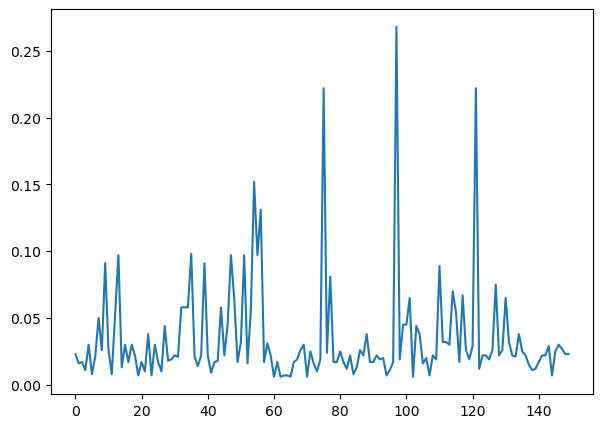

In [27]:
plt.plot(np.array(intervals_len))

Viendo la longitud de los intervalos, parece razonable descartar aquellos más largos que $\epsilon$ = 0.035 (así también nos aseguramos que sacamos a lx paciente mal clasificada, `patient_number = 12`). Cuánto mayor este valor, más pacientes serán clasificadxs en la clase 'no tengo ni idea' y menos pacientes serán clasificadxs automáticamente.

In [28]:
epsilon_bool = np.array(intervals_len) < 0.035 #gives bollean True/False in the condition

In [29]:
certain_predictions = np.array(conform_proba)[epsilon_bool] #takes True 

In [30]:
print('Number of patients in test set =', len(X_test))
print('Number of automatic classifications =',len(certain_predictions))
print('Number of human-assisted classifications =',len(X_test) - len(certain_predictions))

Number of patients in test set = 150
Number of automatic classifications = 113
Number of human-assisted classifications = 37


En aplicaciones reales, puede ser preferible esa inversión en tiempo humano que asumir las clasificaciones incorrectas. Por ejemplo, en nuestro caso, unx expertx en medicina evaluaria a esxs pacientes y las dirigiría a hacerse nuevas pruebas médicas, por ejemplo.

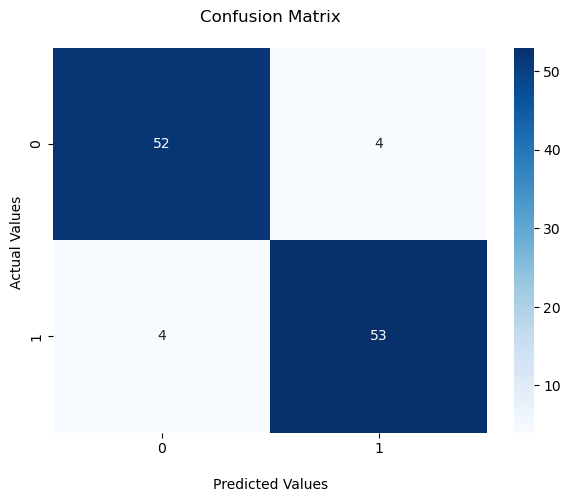

In [31]:
# confusion matrix
t = 0.4

cf_matrix = confusion_matrix(y_test[epsilon_bool], certain_predictions >= t)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

##plt.figure(figsize=(7,5))
plt.rcParams['figure.figsize'] = [7, 5]  # re-run this cell to get the correct figure size

plt.show();

Con la 'Conformal Prediction' hemos detectado las instancias con el intervalo de predicción más largo y las hemos sacado de la clasificación automatica para que las evalue unx expertx. Así hemos conseguido reducir nuestra cantidad de Falsas predicciones un 50%, de 16 a 8 (ver la matriz de confusión que obtuvimos para el conjunto de prueba sin conformar en la sección <a href=#model-RF>3.2 Entrenamiento, prueba, y aplicación del bosque aleatorio</a>).

<font size="5"> 🥳 </font>

En realidad ésta es la implementación más sencilla, muy general, pero hay otras específicas para reducir la cantidad de Falsos Negativos, que es nuestro objetivo (con la implementación IVAP solo hemos obtenido 2 Falsos Negativos menos).

<font color=#6B8E23 size="4"> Material adicional y referencias</font>

Cursos, charlas, y blogs

+ El curso gratuito de Christopher Molnar (subscríbete [aquí](https://substack.com/sign-in?redirect=%2Faccount%3Futm_source%3Dsubstack%26utm_medium%3Demail&for_pub=mindfulmodeler&email=&with_password=&change_user=false&justTrying=)), el autor del maravilloso libro gratuito sobre XAI [_"Interpretable Machine Learning"_](https://christophm.github.io/interpretable-ml-book/), que recomendamos en el Jupyter Notebook `XAI.ipynb`, que ahora se ha pasado a la UQ y ha publicado un libro sobre Conformal Prediction [_"Introduction To Conformal Prediction With Python. A Short Guide For Quantifying Uncertainty Of Machine Learning Models"_](https://christophmolnar.com/books/conformal-prediction/) <font size="3">♫♫🎈♫♫</font>.
+ La maravillosa charla _"Quantifying uncertainty in Machine Learning predictions"_ de [Maria Navarro](https://youtu.be/r6bhm_A-YcQ).
+ La charla sobre Conformal Predictors en el [curso sobre incertidumbre de la Universidad de Pennsylvania](https://uncertaintyclass.com/), este es el [vídeo](https://youtu.be/M3tkM4dcIPA)
+ El blog de los creadores de los 'Conformal Predictors'  [Prof. Vladimir Vovk y Prof. Alex Gammerman](https://cml.rhul.ac.uk/cp.html).
+ El repositorio ['Awesome Conformal Prediction'](https://github.com/valeman/awesome-conformal-prediction) y los artículos de Medium de Valery Manokhin del grupo de investigación que creó la 'Conformal Prediction'.

Librerías

+ Los paquetes de Python [MAPIE](https://lnkd.in/eXx-a-aK) y [nonconformist](https://github.com/donlnz/nonconformist/blob/master/README.ipynb) compatibles con Scikit-learn.
+ Teoría y ejemplos en el repositorio [A. Angelopoulos](https://github.com/aangelopoulos/conformal-prediction), uno de los dos autores de [_"A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification_"](https://arxiv.org/abs/2107.07511).
+ El 'framework' de IBM [AIF360](https://github.com/Trusted-AI/AIF360/blob/master/examples/README.md) para mitigar sesgos y que también recomendamos en el Jupyter Notebook `XAI.ipynb`, incluye técnicas como la clasificación con opción de rechazo o 'Reject Option-based Classification' (ROC), también llamada 'Selective Prediction', un método que asume que el modelo de aprendizaje automático asignó 'raw scores' cercanas al valor del umbral de decisión a aquellas predicciones de las que estaba menos seguro, como por ejemplo, la de le perre que parecía un poco une gate en la foto central de las imágenes de la sección <a href=#project-description-intro>1.1 Introducción</a>) y las separa en una nueva clase, es decir, los resultados posibles son '0', '1', y 'no tengo ni idea'.
+ El 'framework' de IBM [UQ360](https://uq360.mybluemix.net/) con muchos métodos de UQ e incluye [tutoriales](https://uq360.mybluemix.net/resources/tutorials) y una [guía de algoritmos y métricas](https://uq360.mybluemix.net/resources/guidance).

<a name='uq-regression'/>

### <font color=#ac6240>4.2 Otros métodos de UQ para aprendizaje supervisado</font>

La 'Conformal prediction' puede aplicarse para todo tipo de modelos de aprendizaje automático. Sin embargo, al contrario que la mayoría de los métodos de explicabilidad que mostramos en el Jupyter Notebook anterior `XAI.ipynb`, muchos métodos de UQ son específicos, por ejemplo, se aplican solo a tareas de regresión. Mencionaremos algunos muy populares y cabe mencionar que todos ellos se deben calibrar con 'Conformal predictions' o estamos en las mismas:

<font color=#ac6240>Quantile Regresion</font>

+ [Introducción a la Quantile Regression con código](https://www.mygreatlearning.com/blog/what-is-quantile-regression/).
+ La charla _"Asegurando el tiro: intervalos de confianza para tus modelos de Machine Learning"_ de [Ángel Luengo y Guillermo Delgado Martínez](https://charlas.2022.es.pycon.org/pycones2022/talk/NXGNSB/) en la PyConES 2022 que incluye ejemplos del cálculo de la 'Quantile Regression' con 'Gradiente Boosting Machines'.
+ Para 'conformalizar' la 'Quantile Regression' ver [_"A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification"_](https://arxiv.org/pdf/2107.07511.pdf) sección "2. Examples of Conformal Procedures".

<font color=#ac6240>Time Series</font>

+ La explicación de cómo usar la libreria `MAPIE` con los Conformal Predictors para UQ en time series: [_"Time Series Forecasting with Conformal Prediction Intervals: Scikit-Learn is All you Need"_](https://towardsdatascience.com/time-series-forecasting-with-conformal-prediction-intervals-scikit-learn-is-all-you-need-4b68143a027a).
+ [NeuralProphet](https://pypi.org/project/neuralprophet/), basado en Prophet, tiene implementada la función `.conformal_predict()` para calcular Conformal Predictors en time series, [este Jupyter Notebook](https://github.com/ourownstory/neural_prophet/blob/main/tutorials/feature-use/uncertainty_conformal_prediction.ipynb) contiene un ejemplo prediciendo la demanda de energia de un hospital. 

<font color=#ac6240>Ensembles</font>

+ Suelen ser computacionalmente costosos porque implican reentrenar los modelos de aprendizaje automático.
+ El artículo  [_"Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles"_](https://papers.nips.cc/paper/2017/hash/9ef2ed4b7fd2c810847ffa5fa85bce38-Abstract.html).

<font color=#ac6240>Bayesianos</font>

+ Este artículo en este blog: [El Paradigma Bayes para escenarios de incertidumbre](https://keepler.io/es/2020/03/el-paradigma-bayes-para-escenarios-de-incertidumbre/).

+ La librería de Python [PyMC3](https://pypi.org/project/pymc3/) (que ahora se llama [PyMC](https://www.pymc.io/blog/v4_announcement.html)) y el repo [Probabilistic Python: An Introduction to Bayesian Modeling with PyMC](https://github.com/fonnesbeck/probabilistic_python).

+ Métodos Bayesianos para clasificación y regresión como BART [Bayesian Additive Regression Trees](https://jmloyola.github.io/posts/2019/06/introduction-to-bart)

<font color=#ac6240>Procesos Gaussianos</font>

+ Para 'Gaussian Processes', ver por ejemplo: [_"Easy introduction to gaussian process regression (uncertainty models)"_](https://youtu.be/iDzaoEwd0N0) y [_"Coding gaussian process regressors FROM SCRATCH in python"_](https://youtu.be/JXdrq7--XV0) con este [repo](https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification/-/blob/main/coing_gpr_from_scratch_notebook.ipynb).

+ Para Deep Learning, la charla _"Are you sure about that?! Uncertainty Quantification in AI"_ de [Florian Wilhelm](https://youtu.be/LCDIqL-8bHs) con aplicaciones en Deep Learning para tareas de regresión.

<font color=#ac6240>GAMLSS</font>
+ Los Generalized Additive Models for Location, Scale and Shape son modelos de regresión que no predicen los valores de la variable de destino o 'target' sino que predicen los parametros que definen su distribución, es decir, la localización (por ejemplo, la media), la escala (por ejemplo, la varianza), y la forma (por ejemplo, la kurtosis y la 'skewness'), más info en [este artículo](https://www.cienciadedatos.net/documentos/63_gamlss.html).    

<a name='miscelanea'/>

### <font color=#ac6240>4.3 Miscelánea</font>

<font color=#ac6240>Causal Inference</font>

+ Blogs como [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) 
+ Frameworks como [Azure EconML](https://econml.azurewebsites.net/spec/causal_intro.html), [Microsoft DoWhy](https://github.com/py-why/dowhy), o [Uber CausalML](https://github.com/uber/causalml) 
+ La charla _"Introducción a la causalidad en Python "_ de [Albert Pujol Torras y Miguel F. Alarcón](https://charlas.2022.es.pycon.org/pycones2022/talk/FTGTLS/) en la PyConES 2022.

<font color=#ac6240>Modelos híbridos</font>

Son aquellos que incluyen 'domain expertise' para comprobar que se cumplen las restricciones que tenga el sistema, (por ejemplo las leyes de conservación de la energía y la masa, limitaciones de presupuesto,...) o para 'feature engineering'; un ejemplo son las Physic Guided o [Physic Informed Neural Networks](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) como en el artículo [_"Physics-guided Neural Networks (PGNN): An Application in Lake Temperature Modeling"_](https://arxiv.org/pdf/1710.11431.pdf) un ejemplo de una red neuronal artificial aplicada en hidrología que arrojaba soluciones que permitían que agua líquida más densa flotara sobre agua líquida menos densa. 

**Si es que si no se lo dices, todo esto al algoritmo le da igual**.



<font size="6">🤦🏻‍♀️</font>

<font color=#ac6240>Reinforcement Learning</font>

Evita problemas de 'overfitting', puntuaciones no calibradas, sesgos,... usando 'Reinforcement Learning',  en la PyConES 2022 tenemos la charla _"Introducción al aprendizaje por refuerzo en Python"_ de [Antonio Manjavacas y Alejandro Campoy Nieves](https://charlas.2022.es.pycon.org/pycones2022/talk/KVHWPW/) y un buen curso online gratuito es [Stanford CS234: Reinforcement Learning | Winter 2019 by Emma Brunskill](https://youtube.com/playlist?list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u).

<font size="6">🚀</font>

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='uq-end'/>

### <font color=#ac6240>5. Conclusión sobre la cuantificación de incertidumbre</font>

Con los métodos de UQ hemos conseguido:
+ identificar la aquellos pacientes sobre cuya clasificacion el bosque aleatorio no estaba muy seguro, y 
+ reducir nuestra cantidad de Falsos Negativos y Positivos. 

Vemos que son métodos fáciles de implementar y rápidos, y nos proporcionan probabilidades rigurosas.


<font size="5">🎈♫♫🎈🎈♫🎈♫♫♫♫🎈🎈 ♫♫♫ 🎈🎈</font>

<a href=#toc>Subir a Tabla de Contenidos</a><br>

Ya no queda tiempo para más, nos vemos en el próximo taller. 

<font size="5">☀️⛱️ </font> Buen trabajo y hasta pronto!

